# Part 1: Uncertainty and Monte Carlo

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/Desktop/SLR-to-BI-4750`


In [2]:
using Random # random number generation
using Distributions # probability distributions and interface
using Statistics # basic statistical functions, including mean
using Plots # plotting
using DataFrames
# using Measures
# using MarkdownTables
using XLSX
using CSV
using Dates
using StatsModels
using GLM

## Overview

1. Graph SLR by emissions scenario [SSP126](https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool?psmsl_id=12&data_layer=scenario) to test. We will return to graph the remaining scenarios.
2. Make a normal distribution from the **17th-83rd** quantile for yearly estimate. Should this be 5-95th percentile instead?
3. Using [historical sea level data](https://tidesandcurrents.noaa.gov/waterlevels.html?id=8518750&units=metric&bdate=19500101&edate=20171231&timezone=GMT&datum=MSL&interval=m&action=data) and [historical flooding data] develop a relationship between flooding events and SLR.
4. Use a Monte Carlo simulation to sample from the distribution at **year 2130**. If we want to change the year, we should only need to edit the distribution curve.

*Extra stuff idk*
THE DATA https://www.ncdc.noaa.gov/stormevents/listevents.jsp?eventType=ALL&beginDate_mm=01&beginDate_dd=01&beginDate_yyyy=1950&endDate_mm=12&endDate_dd=01&endDate_yyyy=2017&county=NEW%2BYORK%3A61&hailfilter=0.00&tornfilter=0&windfilter=000&sort=DT&submitbutton=Search&statefips=36%2CNEW+YORK
https://www.fema.gov/data-visualization/historical-flood-risk-and-costs

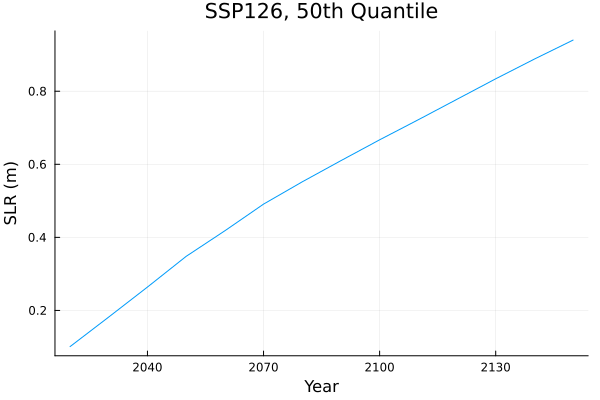

In [10]:
# load the data, pull Zone C, and reformat the DataFrame
slr = DataFrame(XLSX.readtable("data/ipcc_ar6_sea_level_projection_psmsl_id_12.xlsx", "Total"))
filtered_data = filter(row -> row.scenario == "ssp126" && row.quantile == 50, slr) # scenario "ssp126" and quantile 50 to test
years = 2020:10:2150 # time interval every 10 years
sea_levels = collect(filtered_data[1, Symbol.(string.(years))]) 
# plot demand
plot(years, sea_levels, xlabel="Year", ylabel="SLR (m)", title="SSP126, 50th Quantile", legend=false)

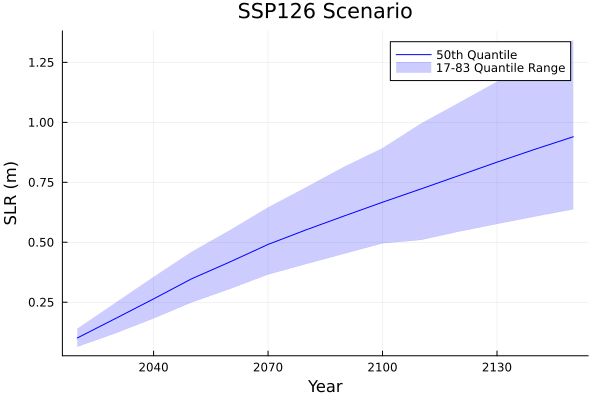

In [11]:
slr = DataFrame(XLSX.readtable("data/ipcc_ar6_sea_level_projection_psmsl_id_12.xlsx", "Total"))
years = 2020:10:2150

# data for 17th, 50th, and 83rd quantiles in SSP126 scenario
data_25 = filter(row -> row.scenario == "ssp126" && row.quantile == 17, slr)
data_50 = filter(row -> row.scenario == "ssp126" && row.quantile == 50, slr)
data_75 = filter(row -> row.scenario == "ssp126" && row.quantile == 83, slr)

# find sea level data for each quantile
sea_levels_25 = Vector{Float64}(data_25[1, Symbol.(string.(years))])
sea_levels_50 = Vector{Float64}(data_50[1, Symbol.(string.(years))])
sea_levels_75 = Vector{Float64}(data_75[1, Symbol.(string.(years))])

plot(years, sea_levels_50, label="50th Quantile", color=:blue, lw=1, xlabel="Year", ylabel="SLR (m)", title="SSP126 Scenario")
plot!(years, sea_levels_25, fillrange=sea_levels_75, label="17-83 Quantile Range", color=:blue, lw=0, fillalpha=0.2)

In [12]:
# Index year 2130
year_index = findfirst(x -> x == 2130, years)

# Filter data for scenario 'ssp126' and year 2130, handling missing values
data = filter(row -> row.scenario == "ssp126" && !ismissing(row[Symbol(string(years[year_index]))]), slr)

# Extract the values for year 2130 as a vector
at2130 = [row[Symbol(string(years[year_index]))] for row in eachrow(data)]

# Print the vector of all SLR values at year 2130 for the ssp126 scenario
println("SLR values at year 2130: ", at2130)


SLR values at year 2130: [0.449, 0.577, 0.834, 1.17, 1.424, 0.449, 0.577, 0.858, 1.255, 1.665]


In [15]:
σ = std(at2130)
μ = mean(at2130)
# μ is the mean and σ is the standard deviation
normal_distribution = Normal(μ, σ)

Normal{Float64}(μ=0.9258, σ=0.4312320334421675)

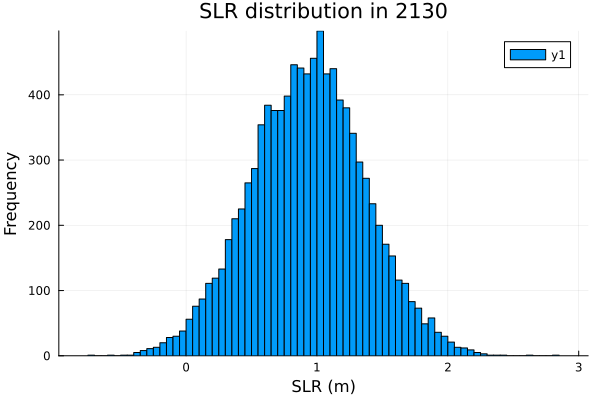

In [16]:
showcase_samples = rand(normal_distribution, 10_000)
histogram(showcase_samples, xlabel="SLR (m)", ylabel="Frequency", title="SLR distribution in 2130")

## Here I will try to plot historical data to build a relationship between flooding and SLR
Good news! I plotted the data. Bad news: I found more SLR --> less flooding. Maybe it's just extra beachfront property after all...

In [35]:
# Load the CSV data into a DataFrame
history = CSV.read("data/CO-OPS_8518750_met.csv", DataFrame)
# MSL = Mean Sea Level Rise
first(history, 5)

Row,Date,Time (GMT),Highest,MHHW (m),MHW (m),MSL (m),MTL (m),MLW (m),MLLW (m),Lowest (m),Inf
,String15,Time,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Int64
1,1950/01/01,00:00:00,0.836,NaN,0.373,-0.258,-0.285,-0.944,NaN,-1.45,0
2,1950/02/01,00:00:00,1.141,NaN,0.419,-0.206,-0.234,-0.886,NaN,-1.633,0
3,1950/03/01,00:00:00,0.928,NaN,0.297,-0.34,-0.365,-1.026,NaN,-1.755,0
4,1950/04/01,00:00:00,0.989,NaN,0.483,-0.179,-0.197,-0.877,NaN,-1.297,0
5,1950/05/01,00:00:00,0.989,NaN,0.507,-0.17,-0.188,-0.883,NaN,-1.206,0


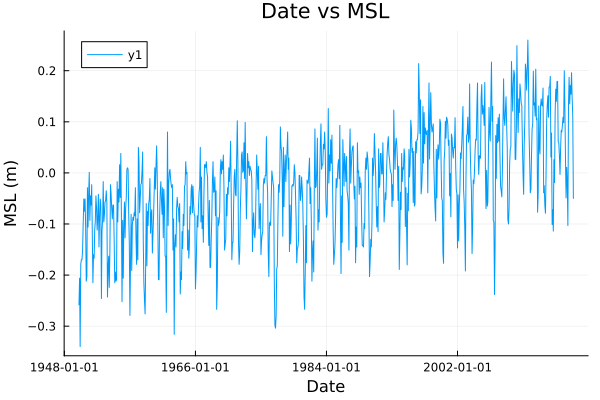

In [88]:
history.Date = Date.(history.Date) 
rename!(history, "MSL (m)" => "MSL")
plot(history.Date, history."MSL", xlabel="Date", ylabel="MSL (m)", title="Date vs MSL")

In [ ]:
floods = CSV.read("data/storm_data_search_results.csv", DataFrame)

┌ Warning: thread = 1 warning: only found 38 / 39 columns around data row: 39. Filling remaining columns with `missing`
└ @ CSV /Users/cellaschnabel/.julia/packages/CSV/XLcqT/src/file.jl:592
┌ Warning: thread = 1 warning: only found 38 / 39 columns around data row: 39. Filling remaining columns with `missing`
└ @ CSV /Users/cellaschnabel/.julia/packages/CSV/XLcqT/src/file.jl:592
┌ Warning: thread = 1 warning: only found 1 / 39 columns around data row: 40. Filling remaining columns with `missing`
└ @ CSV /Users/cellaschnabel/.julia/packages/CSV/XLcqT/src/file.jl:592
┌ Warning: thread = 1 warning: only found 1 / 39 columns around data row: 40. Filling remaining columns with `missing`
└ @ CSV /Users/cellaschnabel/.julia/packages/CSV/XLcqT/src/file.jl:592
┌ Warning: thread = 1 warning: only found 38 / 39 columns around data row: 39. Filling remaining columns with `missing`
└ @ CSV /Users/cellaschnabel/.julia/packages/CSV/XLcqT/src/file.jl:592
┌ Warning: thread = 1 warning: only found 1 / 3

Row,EVENT_ID,CZ_NAME_STR,BEGIN_LOCATION,BEGIN_DATE,BEGIN_TIME,EVENT_TYPE,MAGNITUDE,TOR_F_SCALE,DEATHS_DIRECT,INJURIES_DIRECT,DAMAGE_PROPERTY_NUM,DAMAGE_CROPS_NUM,STATE_ABBR,CZ_TIMEZONE,MAGNITUDE_TYPE,EPISODE_ID,CZ_TYPE,CZ_FIPS,WFO,INJURIES_INDIRECT,DEATHS_INDIRECT,SOURCE,FLOOD_CAUSE,TOR_LENGTH,TOR_WIDTH,BEGIN_RANGE,BEGIN_AZIMUTH,END_RANGE,END_AZIMUTH,END_LOCATION,END_DATE,END_TIME,BEGIN_LAT,BEGIN_LON,END_LAT,END_LON,EVENT_NARRATIVE,EPISODE_NARRATIVE,ABSOLUTE_ROWNUMBER,Column40,Column41,Column42,Column43,Column44,Column45,Column46,Column47,Column48,Column49
,String,String?,String?,String?,String?,String?,String?,String31?,String?,String15?,String?,String?,String?,String31?,String3?,String7?,String1?,Int64?,String3?,Int64?,Int64?,String31?,String31?,String7?,String3?,String1?,String3?,String1?,String3?,String31?,String15?,String7?,String15?,String15?,String15?,String15?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String?,String15?,String?,Int64?
1,10075617,NEW YORK CO.,,08/10/1979,1300,Thunderstorm Wind,0,,0,0,0,0,NY,CST,,,C,61,PER,0,0,,,0,0,0,,0,,,08/10/1979,1300,40.73,-74.00,,,missing,missing,1,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
2,10077125,NEW YORK CO.,,08/11/1983,1800,Thunderstorm Wind,0,,0,0,0,0,NY,CST,,,C,61,AT,0,0,,,0,0,0,,0,,,08/11/1983,1800,40.73,-74.00,,,missing,missing,2,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
3,10076357,NEW YORK CO.,,06/24/1985,1245,Hail,1.00,,0,0,0,0,NY,CST,,,C,61,R,0,0,,,0,0,0,,0,,,06/24/1985,1245,40.78,-73.93,,,missing,missing,3,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
4,10077475,NEW YORK CO.,,08/30/1985,1410,Hail,1.00,,0,0,0,0,NY,CST,,,C,61,R,0,0,,,0,0,0,,0,,,08/30/1985,1410,40.77,-73.93,,,missing,missing,4,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing
5,10076612,NEW YORK CO.,,11/20/1989,2031,Thunderstorm Wind,66,,0,0,0,0,NY,CST,,,C,61,NYC,0,0,,,0,0,0,,0,,,11/20/1989,2031,40.78,-73.87,,,missing,missing,5,missing,missing,missing,missing,missing,missing,missing,missing,missing,missing


In [42]:
# ANY row that has the word 'Flood' (there are flash floods, coastal floods, regular floods, etc.)
# where it's not missing data
flood_rows = filter(row -> !ismissing(row.EVENT_TYPE) && occursin(r"(?i)flood", row.EVENT_TYPE), floods)
flood_dates = DateTime.(flood_rows.BEGIN_DATE, "mm/dd/yyyy")
formatted_dates = Date.(flood_dates)

65-element Vector{Date}:
 1996-01-07
 1996-01-12
 1996-01-19
 1996-04-16
 1996-06-03
 1996-07-08
 1996-10-19
 1996-10-19
 1996-10-19
 1996-12-06
 ⋮
 2011-08-28
 2011-08-28
 2011-08-28
 2012-07-18
 2012-10-29
 2013-06-02
 2013-06-07
 2017-05-05
 2017-05-05

In [ ]:
flood_years = year.(formatted_dates)
flood_year_df = DataFrame(Year = flood_years)

# Count the occurrences of each year
flood_counts_by_year = combine(groupby(flood_year_df, :Year), nrow => :Flood_Count)

flood_counts_by_year

Row,Year,Flood_Count
,Int64,Int64
1,1996,12
2,1997,1
3,1998,4
4,1999,2
5,2001,4
6,2002,1
7,2003,2
8,2004,6
9,2005,2


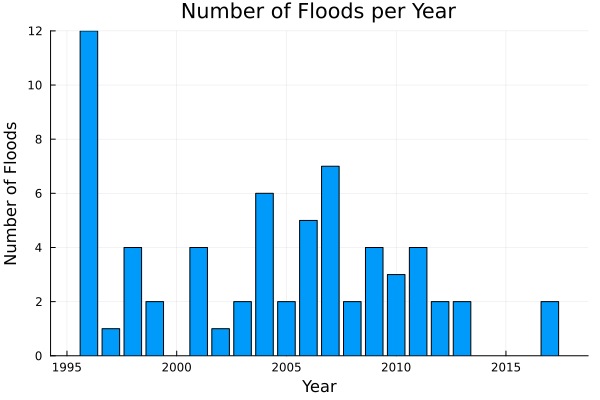

In [ ]:
years = flood_counts_by_year.Year
flood_counts = flood_counts_by_year.Flood_Count
bar(years, flood_counts, xlabel="Year", ylabel="Number of Floods", title="Number of Floods per Year", legend=false)

In [89]:
history.Date = Date.(string.(history.Date), "yyyy-mm-dd")
history.Year = year.(history.Date)

flood_data = filter(row -> row.Year in flood_years, history)

average_msl_by_year = combine(groupby(flood_data, :Year), "MSL" => mean)
average_msl_by_year[!, :flood_counts] = flood_counts

println(average_msl_by_year)

18×3 DataFrame
 Row │ Year   MSL_mean     flood_counts 
     │ Int64  Float64      Int64        
─────┼──────────────────────────────────
   1 │  1996   0.06825               12
   2 │  1997   0.0455833              1
   3 │  1998   0.068                  4
   4 │  1999   0.0155833              2
   5 │  2001   0.0234167              4
   6 │  2002  -0.0135                 1
   7 │  2003   0.0211667              2
   8 │  2004   0.0186667              6
   9 │  2005   0.0820833              2
  10 │  2006   0.0575833              5
  11 │  2007   0.00241667             7
  12 │  2008   0.0605                 2
  13 │  2009   0.08775                4
  14 │  2010   0.124333               3
  15 │  2011   0.120417               4
  16 │  2012   0.0948333              2
  17 │  2013   0.06175                2
  18 │  2017   0.0891667              2


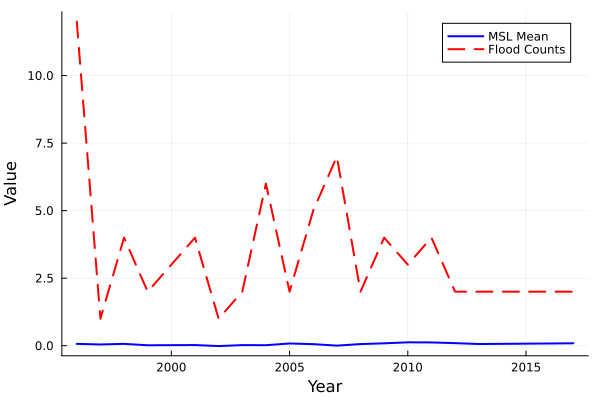

In [96]:
plot(average_msl_by_year.Year, average_msl_by_year.MSL_mean, label="MSL Mean", xlabel="Year", ylabel="Value", color=:blue, linewidth=2)
plot!(average_msl_by_year.Year, average_msl_by_year.flood_counts, label="Flood Counts", color=:red, linewidth=2, linestyle=:dash)

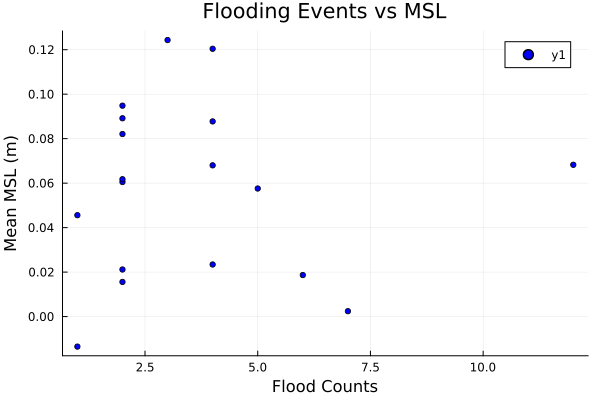

In [90]:
scatter(average_msl_by_year.flood_counts, average_msl_by_year."MSL_mean",
        xlabel="Flood Counts", ylabel="Mean MSL (m)",
        title="Flooding Events vs MSL", markersize=3, color="blue")

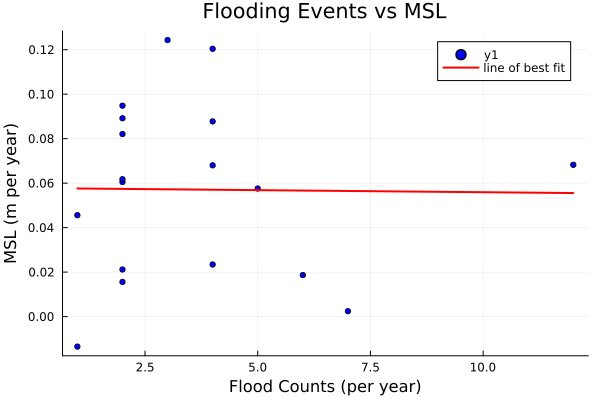

In [ ]:
# make a linear model
model = lm(@formula(MSL_mean ~ flood_counts), average_msl_by_year)

scatter(average_msl_by_year.flood_counts, average_msl_by_year."MSL_mean",
        xlabel="Flood Counts (per year)", ylabel="MSL (m per year)",
        title="Flooding Events vs MSL", markersize=3, color="blue")

plot!(average_msl_by_year.flood_counts, predict(model), label="line of best fit", color=:red, linewidth=2)

# Here I will make some hyper simplifications for proof of concept

In [ ]:
# this is the money shot. We're broke rn
function inland_flooding(slr; a = 0.5)
    return a * slr 
end

inland_flooding (generic function with 2 methods)

In [ ]:
# i think this code might actually be good
Random.seed!(1)  # Set seed for reproducibility
simulations = 1000
expected_values = []

iterations = 1:simulations
for i in iterations
    slr_sample = rand(showcase_samples)  # showcase_samples defined from actual data
    exval = inland_flooding(slr_sample)
    push!(expected_values, exval)
end

In [41]:
ev_temp_2100 = mean(expected_values)
st_dev_2100 = std(expected_values)

0.2207654328619404

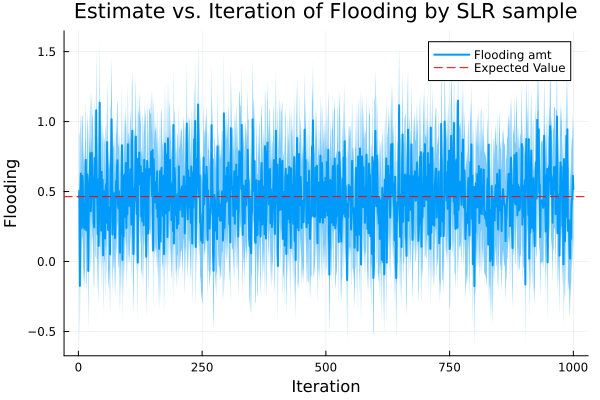

In [42]:
plt = plot(
    iterations, expected_values, 
    ribbon=1.96 * st_dev_2100, 
    xlabel="Iteration", 
    ylabel="Flooding", 
    label="Flooding amt", 
    title="Estimate vs. Iteration of Flooding by SLR sample", 
    lw=2, 
    legend=:topright
)

hline!(plt, [ev_temp_2100], color="red", linestyle=:dash, label="Expected Value")

It doesn’t matter what seed you set, though different seeds might result
in slightly different values. But setting a seed means every time your
notebook is run, the answer will be the same.

> **Seeds and Reproducing Solutions**
>
> If you don’t re-run your code in the same order or if you re-run the
> same cell repeatedly, you will not get the same solution. If you’re
> working on a specific problem, you might want to re-use
> `Random.seed()` near any block of code you want to re-evaluate
> repeatedly.

### Probability Distributions and Julia

Julia provides a common interface for probability distributions with the
[`Distributions.jl`
package](https://juliastats.org/Distributions.jl/stable/). The basic
workflow for sampling from a distribution is:

1.  Set up the distribution. The specific syntax depends on the
    distribution and what parameters are required, but the general call
    is the similar. For a normal distribution or a uniform distribution,
    the syntax is

    ``` julia
    # you don't have to name this "normal_distribution"
    # μ is the mean and σ is the standard deviation
    normal_distribution = Normal(μ, σ)
    # a is the upper bound and b is the lower bound; these can be set to +Inf or -Inf for an unbounded distribution in one or both directions.
    uniform_distribution = Uniform(a, b)
    ```

    There are lots of both
    [univariate](https://juliastats.org/Distributions.jl/stable/univariate/#Index)
    and
    [multivariate](https://juliastats.org/Distributions.jl/stable/multivariate/)
    distributions, as well as the ability to create your own, but we
    won’t do anything too exotic here.

2.  Draw samples. This uses the `rand()` command (which, when used
    without a distribution, just samples uniformly from the interval
    $[0, 1]$.) For example, to sample from our normal distribution
    above:

    ``` julia
    # draw n samples
    rand(normal_distribution, n)
    ```

Putting this together, let’s say that we wanted to simulate 100
six-sided dice rolls. We could use a [Discrete Uniform
distribution](https://juliastats.org/Distributions.jl/stable/univariate/#Distributions.DiscreteUniform).

In [4]:
dice_dist = DiscreteUniform(1, 6) # can generate any integer between 1 and 6
dice_rolls = rand(dice_dist, 100) # simulate rolls

100-element Vector{Int64}:
 1
 3
 5
 4
 6
 2
 5
 5
 5
 2
 ⋮
 3
 6
 5
 5
 6
 3
 6
 6
 6

And then we can plot a histogram of these rolls:

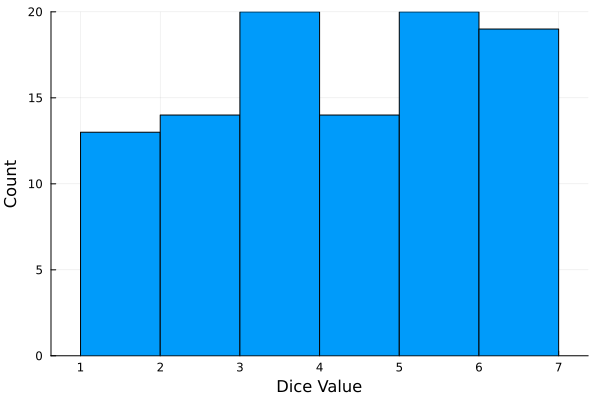

In [5]:
histogram(dice_rolls, legend=:false, bins=6)
ylabel!("Count")
xlabel!("Dice Value")

### Instructions

**Remember to**:

-   Evaluate all of your code cells, in order (using a `Run All`
    command). This will make sure all output is visible and that the
    code cells were evaluated in the correct order.
-   Tag each of the problems when you submit to Gradescope; a 10%
    penalty will be deducted if this is not done.

## Exercise (3 Points)

The Showcase is the final round of every episode of The Price is Right,
matching the two big winners from the episode. Each contestant is shown
a “showcase” of prizes, which are usually some combination of a trip, a
motor vehicle, some furniture, and maybe some other stuff. They then
each have to make a bid on the retail price of the showcase. The rules
are:

-   an overbid is an automatic loss;
-   the contest who gets closest to the retail price wins their
    showcase;
-   if a contestant gets within \$250 of the retail price and is closer
    than their opponent, they win both showcases.

Your goal is to find a wager which maximizes your expected winnings,
which we may as well call utility, based on your assessment of the
probability of your showcase retail price. Make the following
assumptions about your expected winnings if you don’t overbid:

-   If you win both showcases, the value is the double of the single
    showcase value.
-   If you did not win both showcases but bid under the showcase value,
    the probability of being outbid increases linearly as the distance
    between your bid and the value increases (in other words, if you bid
    the exact value, you win with probability 1, and if you bid \$0, you
    win with probability 0).

We’ll assume that the distribution of all showcases offered by the show
is given as truncated normal distribution, which means a normal
distribution which has an upper and/or lower bound. `Distributions.jl`
makes it easy to specify truncations on any distribution, not just
normal distributions. For example, we’ll use the distribution shown in
<a href="#fig-values" class="quarto-xref">Figure 1</a> for the showcase
values (you can just directly use the `showcase_dist` distribution in
your lab code).

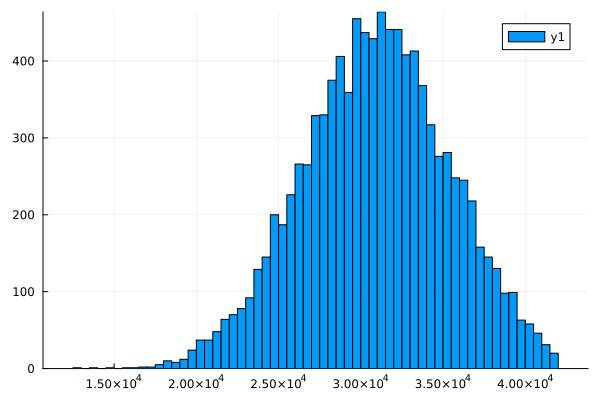

In [6]:
showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
showcase_samples = rand(showcase_dist, 10_000)
histogram(showcase_samples)

Find your expected winnings if you bid \$35,000. Plot the outcomes of
your Monte Carlo experiment (iterations vs. running estimate). How did
you decide how many samples to use?

### Exercise
I take i, where i goes from 1 to 1000, random numbers from the showcase distribution, assuming that the distribution is given as truncated normal distribution with lower bound 5,000 and upper bound 42,000. I calculate the expected value of winnings based on  the value of the random number (the value of the prize) in my function priceIsRight. 

**My function: priceIsRight**

    If the value of the random number is less than 35,000 dollars, your bid is too high, so the chance of winning is 0 and the expected value of your winnings is 0.
    If the value of the random number is between 35,250 dollars and 35,000 dollars then your guess is within 250 dollars and your expected value is 2 x the prize (the random number). 
    Otherwise, the probability is calculated by the following equation:
    
    probability = 1 - (random value - 35000) / random value

    and your expected value is

    prize = probability * random value

    I return the mean expected value. 

The mean expected value is around **7,000 dollars** if your bid is 35,000 dollars.

I decided to use 1000 samples (i) because the running estimate starts to converge around 500 and seems to really level off at 1000. I can be confident in my mean expected value because it stays in a reasonable range (between 6,000 and 8,000) at 1000.


In [82]:
Random.seed!(1)
function priceIsRight(x)
    prob = []  
    EV = []
    for rand_num in x
        if rand_num < 35000
            chance_of_winning = 0
            V = 0
            append!(prob, chance_of_winning)
            append!(EV, V)
        elseif 35250 > rand_num > 35000
            chance_of_winning = 1
            V = rand_num * 2
            append!(prob, chance_of_winning)
            append!(EV, V)
        else
            chance_of_winning = 1 - (rand_num - 35000) / rand_num
            V = chance_of_winning*rand_num
            append!(prob, chance_of_winning)
            append!(EV, V)
        end
    end
    return mean(EV)
end

expect = []
for i in 1:1000
    showcase_dist = truncated(Normal(31000, 4500), lower=5000, upper=42000)
    showcase_samples = rand(showcase_dist, i)
    exval = priceIsRight(showcase_samples)
    append!(expect, exval)
end

print(mean(expect))

6920.860980388288

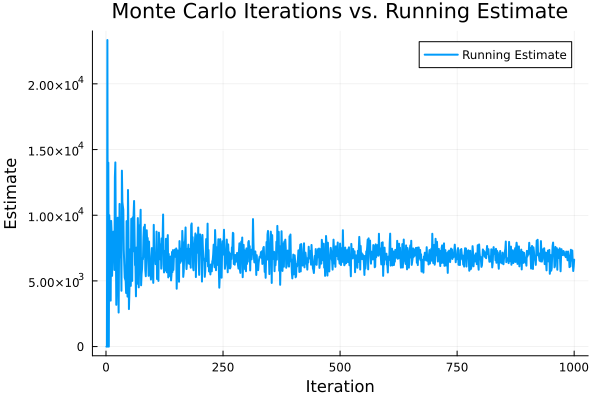

In [84]:
# interation vs running estimate
iterations = 1:1000
plot(iterations, expect, label="Running Estimate", xlabel="Iteration", ylabel="Estimate", title = "Monte Carlo Iterations vs. Running Estimate", lw=2, legend=:topright)

## References

Put any consulted sources here, including classmates you worked with/who
helped you.

My friend Tis helped me with the equalities in my if statements from function priceIsRight.